# Preprocessing and Observing Data
In this notebook, we aim to observe the data behavior, and choose features of importance carefully. We shall make use of functions and classes that we have written in `train.py`, `dataloader.py`, and `model.py`.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from dataloader import seq_collate, preprocess, exam_loader
from model import Predictor
from train import str_current_time, log, process, Scheduler

In [2]:
import os
import pathlib
import yaml

# Working directory setup
loader_root = "./loader.yml"
loader_config = yaml.load(open(loader_root, 'r'), Loader=yaml.SafeLoader)
save_dir = os.path.join('./saved_params', 'debug')

In [3]:
# Feature setup
train_root_path = "./datasets/trainSet.csv"
norm_dict = loader_config['norm_factor_dict']
value_feats = loader_config['value_features']
string_feats = loader_config['string_features']
remove_feats = loader_config['remove_features']

In [4]:
from sklearn.impute import SimpleImputer

# Setup dataset as pandas.dataframe
dataset = pd.read_csv(train_root_path)
dataset = dataset.drop(remove_feats, axis=1)

# Impute data for nan values
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

dataset[value_feats] = num_imputer.fit_transform(dataset[value_feats])
dataset[string_feats] = cat_imputer.fit_transform(dataset[string_feats])
dataset = pd.get_dummies(dataset, columns=string_feats)

# Remove sequence data
total_features = [f for f in dataset.columns if 'MONTH' not in f]
dataset = dataset[total_features]

# Normalize data
for feats in norm_dict:
    dataset[feats] /= float(norm_dict[feats])

In [5]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

target_name = 'First 6 mo. Avg. GAS (Mcf)'
value_dataset = dataset[value_feats]
value_dataset[target_name] = dataset[target_name]
high_corr = value_dataset.corr()[target_name].sort_values(ascending=False)

print("Correlation coeffiecents in descending order\n")
print(high_corr)

Correlation coeffiecents in descending order

First 6 mo. Avg. GAS (Mcf)               1.000000
TVD (ft)                                 0.351516
Total Proppant Placed (tonne)            0.342124
Total Sand Proppant Placed (tonne)       0.327256
Avg Proppant Placed per Stage (tonne)    0.303808
Avg Proppant Placed per Stage (tonne)    0.303808
Total Proppant 1 Placed (tonne)          0.290564
Avg Proppant 1 Placed (tonne)            0.260801
Ground Elevation (ft)                    0.252996
Reference (KB) Elev. (ft)                0.250145
Avg Proppant Placed / Meter (tonne)      0.233632
MD (All Wells) (ft)                      0.196756
Avg Fluid Pumped per Stage (m3)          0.175095
Total Fluid Pumped (m3)                  0.170739
Completed Length (m)                     0.161921
Load Fluid (m3)                          0.142068
Avg Fluid Pumped / Meter (m3)            0.112374
Load Fluid Rec (m3)                      0.087686
Stages Actual                            0.032256
Avg 

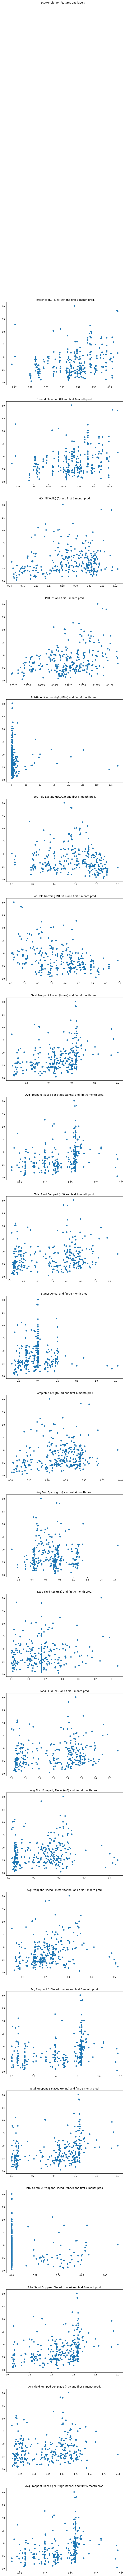

In [6]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,200)
fig, axs = plt.subplots(len(value_feats))
fig.suptitle('Scatter plot for features and labels')
for j, feat in enumerate(value_feats):
    x = dataset[feat]
    y = dataset[target_name] / 1e5
    axs[j].scatter(x, y)
    axs[j].set_title(f'{feat} and first 6 month prod.')